In this notebook I explore some characteristics of Sundarbans Reserve Forest (SRF) using land sector datasets.

Dataset source: https://github.com/moja-global/Land_Sector_Datasets

### Imports

In [1]:
# dataset download
import io, requests, zipfile

# dataframes
import numpy as np
import pandas as pd
import geopandas as gpd

# rasters
import rasterio as rst
from rasterio.plot import show
from rasterio.mask import mask

# plot and graphs
import matplotlib.pyplot as plt
from matplotlib import cm, colors

# ignore warning about missing/empty geometries
import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# earth engine visualizations
import geemap
import ee
# for dependencies
%matplotlib inline

### Countries administrative boundaries

Sundarbans Reserve Forest (SRF) located in the south-west of Bangladesh between the river Baleswar in the East and the Harinbanga in the West, adjoining to the Bay of Bengal, is the largest contiguous mangrove forest in the world.

In order to visualize the forest on the map, the administrative boudaries of the countries listed above will be downloaded and used as a background in futher visualizations.

In [43]:
# Indian Administrative boundries
ind_boundaries = gpd.read_file('Boundries/IND_AL2_India.json')
ind_boundaries  = ind_boundaries[['name', 'geometry']]

In [44]:
# Bangladesh Administrative boundries
ban_boundaries = gpd.read_file('Boundries/BGD_AL2_Bangladesh.json')
ban_boundaries  = ban_boundaries[['name', 'geometry']]

In [45]:
def set_map_limits():
  """
  Sets map's axis ranges.
  """
  plt.xlim(86, 92)
  plt.ylim(20,24)

In [49]:
def plot_countries(df,ax):
  """
  Plots coutries' borders on the map.
  """
  df.plot(ax=ax, color='none', edgecolor='black')

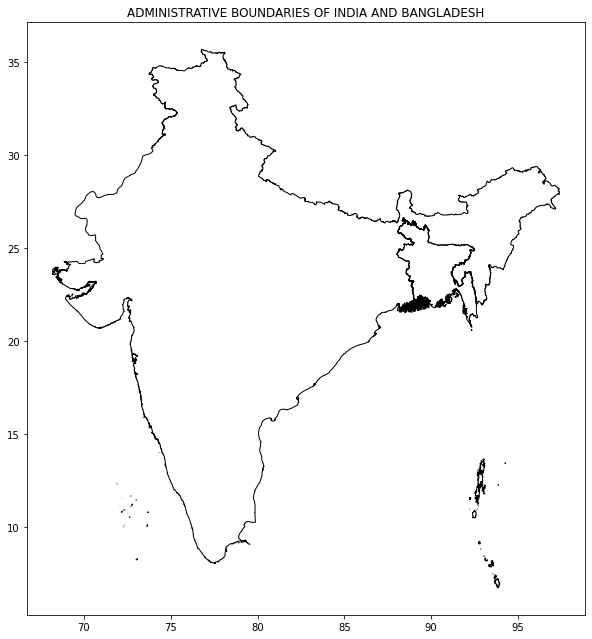

In [50]:
# concatinate all administrative boundaries into one GeoDataFrame
countries_boundaries_df = pd.concat([ind_boundaries, ban_boundaries], axis=0)

# visualize coutries' borders
fig, ax = plt.subplots(figsize=(10, 15))

ax.set_title('ADMINISTRATIVE BOUNDARIES OF INDIA AND BANGLADESH')
# set_map_limits()
plot_countries(countries_boundaries_df,ax)

plt.show()

### Forest on the map

In [51]:
# get geometry and other useful information of the ecoregion
terrestrial_ecoregions_df = gpd.read_file("Ecoregions/TerrestrialEcoregionsoftheWorld_WWF.geojson")


In [52]:
terrestrial_ecoregions_df.head()

,OBJECTID_1,OBJECTID,AREA,ECO_NAME,REALM,BIOME,ECO_NUM,ECO_ID,ECO_SYM,GBL_STAT,...,G200_BIOME,G200_STAT,area_km2,eco_code,BIOME_1,GBL_STAT_1,REALM_1,Shape_Length,Shape_Area,geometry
0,1,1,29.802942,Northern Mesoamerican Pacific mangroves,NT,14,4,61404,119,1,...,0,0,8174,NT1404,,,Neotropics,0.219475,0.002769,"POLYGON ((-112.30433 29.33480, -112.29035 29.3..."
1,2,2,11.977824,Northern Mesoamerican Pacific mangroves,NT,14,4,61404,119,1,...,0,0,8174,NT1404,,,Neotropics,0.193289,0.001111,"POLYGON ((-112.19639 29.20719, -112.19669 29.2..."
2,3,3,77301.372760,Sinaloan dry forests,NT,2,28,60228,98,1,...,2,1,77362,NT0228,,,Neotropics,111.951414,6.879188,"POLYGON ((-108.40314 28.29783, -108.41069 28.3..."
3,4,4,215.489182,Northern Mesoamerican Pacific mangroves,NT,14,4,61404,119,1,...,0,0,8174,NT1404,,,Neotropics,1.273654,0.019701,"POLYGON ((-110.58808 27.85878, -110.59068 27.8..."
4,5,5,19.639089,Northern Mesoamerican Pacific mangroves,NT,14,4,61404,119,1,...,0,0,8174,NT1404,,,Neotropics,0.363068,0.001791,"POLYGON ((-110.53048 27.31542, -110.55385 27.3..."


In [53]:
# Extracting info. about the Sundarbans region
forest_df = terrestrial_ecoregions_df[ terrestrial_ecoregions_df["ECO_NAME"].str.startswith("Sundarbans")]


In [54]:
forest_df.head()

,OBJECTID_1,OBJECTID,AREA,ECO_NAME,REALM,BIOME,ECO_NUM,ECO_ID,ECO_SYM,GBL_STAT,...,G200_BIOME,G200_STAT,area_km2,eco_code,BIOME_1,GBL_STAT_1,REALM_1,Shape_Length,Shape_Area,geometry
4781,4782,9293,2.020684,Sundarbans mangroves,IM,14,6,41406,119,1,...,14,1,20383,IM1406,,,IndoMalay,0.059915,0.000177,"POLYGON ((90.82551 22.59696, 90.81966 22.61363..."
4784,4785,9296,1.840133,Sundarbans mangroves,IM,14,6,41406,119,1,...,14,1,20383,IM1406,,,IndoMalay,0.054115,0.000162,"POLYGON ((90.89134 22.57557, 90.88828 22.58113..."
4788,4789,9300,394.399028,Sundarbans mangroves,IM,14,6,41406,119,1,...,14,1,20383,IM1406,,,IndoMalay,1.017998,0.034561,"POLYGON ((91.13940 22.17282, 91.16162 22.19837..."
7424,7425,6965,3.180244,Sundarbans mangroves,IM,14,6,41406,119,1,...,14,1,20383,IM1406,,,IndoMalay,0.069975,0.000280,"POLYGON ((90.53134 23.05999, 90.54106 23.06471..."
7426,7427,6967,21.014157,Sundarbans mangroves,IM,14,6,41406,119,1,...,14,1,20383,IM1406,,,IndoMalay,0.194459,0.001851,"POLYGON ((90.50855 23.07333, 90.50439 23.07388..."


In [55]:
def plot_forest(ax, color='none', edgecolor='seagreen', linewidth=1):
  """
  Plots forest's boundaries on the map.
  """
  forest_df.plot(ax=ax, color=color, edgecolor=edgecolor, linewidth=linewidth)

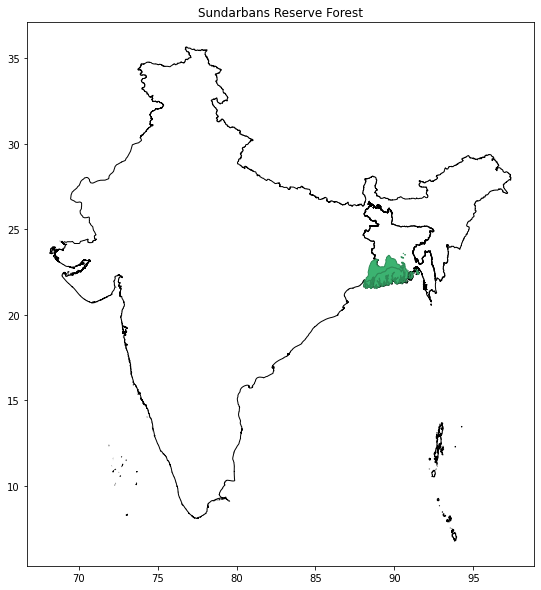

In [56]:
# visualize the forest on the map
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Sundarbans Reserve Forest')
# set_map_limits()
plot_countries(countries_boundaries_df,ax)
plot_forest(ax, color='mediumseagreen')

plt.show()

### General Information

In [57]:
area_km2 = forest_df['area_km2'].unique()[0]
realm    = forest_df['REALM_1'].unique()[0]
biome    = forest_df['BIOME'].unique()[0]
gbl_stat = forest_df['GBL_STAT'].unique()[0]

In [58]:
print(f'Area of the Ecoregion: {area_km2} km2',
      f'Biogeographical Realm: {realm}',
      f'Global Status: {gbl_stat}(vulnerable)',
      f'Biome: {biome}(Temperate Conifer Forests)',
      sep='\n')

Area of the Ecoregion: 20383 km2
Biogeographical Realm: IndoMalay
Global Status: 1(vulnerable)
Biome: 14(Temperate Conifer Forests)


### Climate Zones

In [59]:
# download climate data
climate_df = gpd.read_file("Climate/IPCC_ClimateZoneMap_Vector.geojson")

In [60]:
climate_classification = {
    '1': 'Warm Temperate Moist', 
    '2': 'Warm Temperate Dry', 
    '3': 'Cool Temperate Moist', 
    '4': 'Cool Temperate Dry', 
    '5': 'Polar Moist', 
    '6': 'Polar Dry',
    '7': 'Boreal Moist', 
    '8': 'Boreal Dry',
    '9': 'Tropical Montane', 
    '10': 'Tropical Wet', 
    '11': 'Tropical Dry', 
    '12': 'Tropical Montane Wet', 
    '13': 'Tropical Montane Dry'
}

# normalize column's name
climate_df.rename(columns={'CLASS_NAME': 'class_name'}, inplace=True)

In [61]:
climate_df.head()

,class_name,geometry
0,0,"MULTIPOLYGON (((-37.65000 83.50000, -37.65000 ..."
1,0,"MULTIPOLYGON (((-38.75000 83.40000, -38.75000 ..."
2,0,"MULTIPOLYGON (((-38.60000 83.40000, -38.60000 ..."
3,0,"MULTIPOLYGON (((-37.15000 83.40000, -37.15000 ..."
4,5,"MULTIPOLYGON (((-40.40000 83.40000, -40.40000 ..."


In [62]:
# remove oceans
climate_df = climate_df[climate_df.class_name != 0]

# replace classification codes with actual names
climate_df.class_name = climate_df.class_name.astype('str').replace(climate_classification)

# get only necessary data related to forest
forest_climate_df = climate_df.clip(forest_df)

In [63]:
def plot_features(features_df, ax, column, cmap='Set3'):
  """
  Plots some of the forest's features on the map.
  """
  features_df.plot(ax=ax, cmap=cmap, column=column, legend=True)

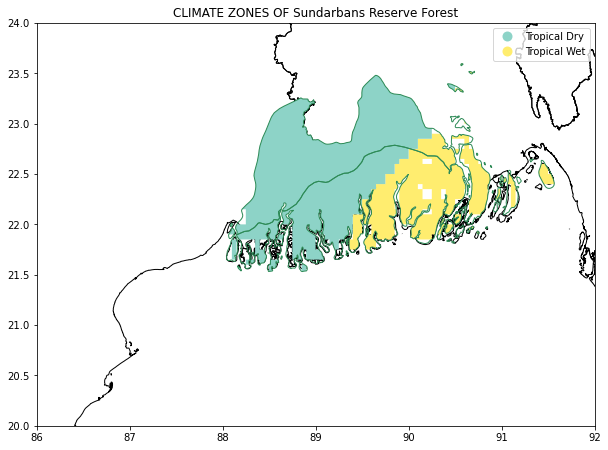

In [64]:
# visualize climate zones on the map
fig, ax = plt.subplots(figsize=(10, 10))
set_map_limits()
ax.set_title('CLIMATE ZONES OF Sundarbans Reserve Forest')

plot_countries(countries_boundaries_df,ax)
plot_features(forest_climate_df, ax=ax, column='class_name')
plot_forest(ax=ax)

plt.show()

### Agro-ecological Zones

In [65]:
# download agro-ecological zones data
agroeco_zones_df = gpd.read_file("AgroEcoZones/GlobalAgroEcologicalZones_GAEZ.geojson")

In [66]:
values = {'1': 'Steep terrain', '2': 'Artic/Cold', '3': 'Desert/Arid', 
          '4': 'Irrigated Soils', '5': 'Hydromorphic soils', 
          '6': 'Dry, good soils', '7': 'Dry, moderate soils', '8': 'Dry, poor soils', 
          '9': 'Moist, good soils', '10': 'Moist, moderate soils', 
          '11': 'Moist, poor soils', '12': 'Sub-humid, good soils', 
          '13': 'Sub-humid, moderate soils', '14': 'Sub-humid, poor soils', 
          '15': 'Humid, good soils', '16': 'Humid, moderate soils', 
          '17': 'Humid, poor soils', '18': 'Water'}

# normalize column's name
agroeco_zones_df.rename(columns={'Value': 'value'}, inplace=True)

# replace classification codes with actual names
agroeco_zones_df.value = agroeco_zones_df.value.astype('str').replace(values)

In [67]:
# get only necessary data related to forest
forest_agroeco_zones_df = agroeco_zones_df.clip(forest_df)

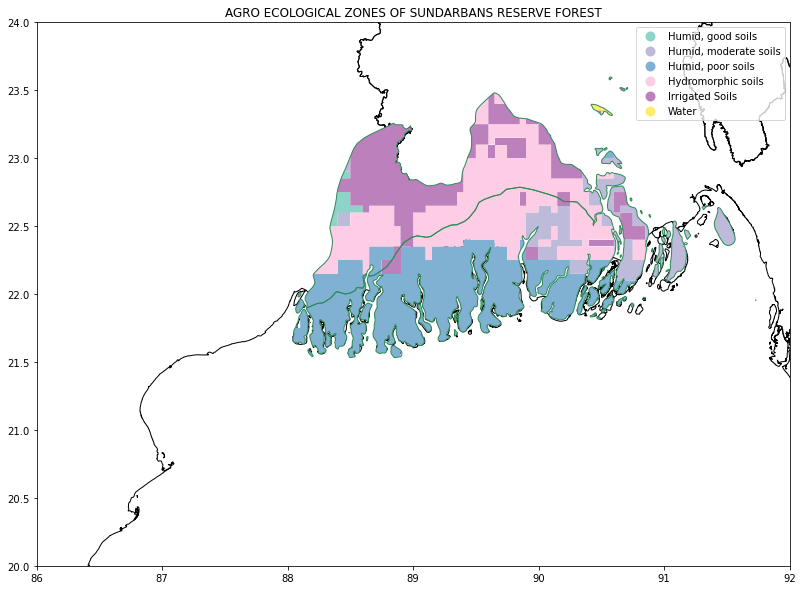

In [69]:
# visualize agro-ecological zones on the map
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('AGRO ECOLOGICAL ZONES OF SUNDARBANS RESERVE FOREST')

set_map_limits()
plot_countries(countries_boundaries_df,ax)
plot_features(forest_agroeco_zones_df, ax=ax, column='value')
plot_forest(ax)

plt.show()

### Holdridge Life Zones

In [70]:
# download holdridge life zones data
holdridge_zones_df = gpd.read_file("Holdridge/HoldridgeLifeZones.json")

In [71]:
# normalize column's name
holdridge_zones_df.rename(columns={'DESC': 'desc'}, inplace=True)

In [72]:
# get only necessary data related to forest
holdridge_zones_df = holdridge_zones_df[['desc', 'geometry']]
forest_holdridge_zones_df = holdridge_zones_df.clip(forest_df)

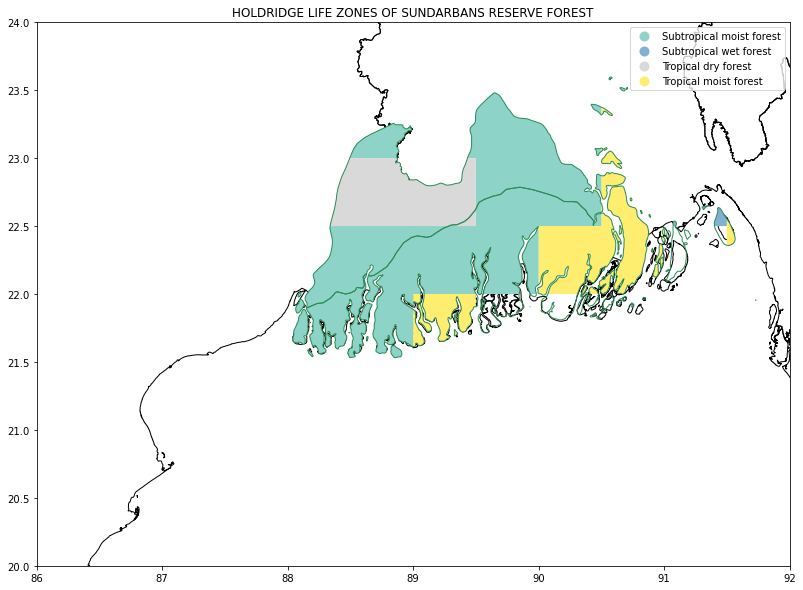

In [74]:
# visualize holdridge life zones on the map
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title('HOLDRIDGE LIFE ZONES OF SUNDARBANS RESERVE FOREST')
set_map_limits()
plot_countries(countries_boundaries_df,ax)
plot_features(forest_holdridge_zones_df, ax=ax, column='desc')
plot_forest(ax)

plt.show()

### Soil Resources

In [75]:
# download soil data
soil_df = gpd.read_file("Soil/World_Soil_Resources_wgs84.geojson")

In [76]:
# normalize column's name
soil_df.rename(columns={'IPCC': 'ipcc'}, inplace=True)

# get only necessary data related to forest
soil_df = soil_df[['ipcc', 'geometry']]
forest_soil_df = soil_df.clip(forest_df)

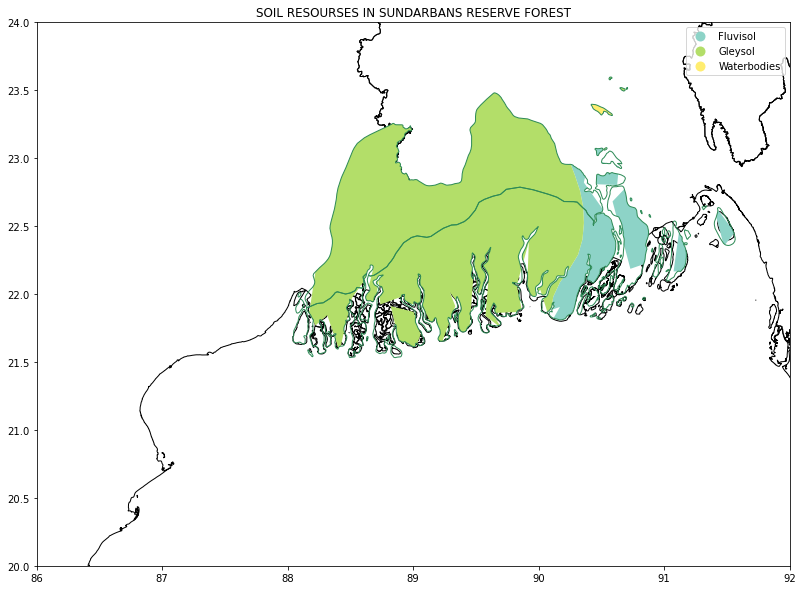

In [77]:
# visualize soil resources on the map
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title('SOIL RESOURSES IN SUNDARBANS RESERVE FOREST')
set_map_limits()
plot_countries(countries_boundaries_df,ax)
plot_features(forest_soil_df, ax=ax, column='ipcc')
plot_forest(ax)

plt.show()